In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [2]:
def plot_train_vs_test_cmp(train_scores, test_scores, spoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    plt.scatter(spoint[0], spoint[1], s=10, c='red')
    w = [-wo[1]/n_features, wo[0]]
    b = w[0]*spoint[0] + w[1]*spoint[1]
    xleft, xright = plt.xlim()
    xd = np.array([xleft, xright])
    yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
    plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    keys = []
    for s in data:
        keys += [k for k in data[s] if not k in keys]

    for x in keys:
        arr[x] = np.nanmean([data[v][x] if x in data[v] else np.nan for v in data])
    return arr

In [3]:
n_features = 200
X, y = make_classification(n_clusters_per_class = 2, n_samples = 8000, n_features = n_features, n_informative = 80, random_state=8, flip_y= 0.01, class_sep=1.1)
X_train, X_test = np.split(X, [600])
y_train, y_test = np.split(y, [600])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# STOPCOND WITHIN RFE

In [4]:
def plot_train_vs_test_old(train_scores, test_scores, w_scores, spoint, wpoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.plot(w_scores.keys(), w_scores.values(), label = "RFE Prediction", zorder = 0)
    
    xleft, xright = plt.xlim()
    def peano_draw(spoint, wo, color = 'red'):
        plt.scatter(spoint[0], spoint[1], s=25, c=color)
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c=color)

    peano_draw(spoint, wo, color='red')
    peano_draw(wpoint, wo, color='green')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    # Project wpoint (pareto optimal of stopcond prediction)
    w_y = np.interp([wpoint[0]], list(test_scores.keys()), list(test_scores.values()))
    w_obj = wo[0] * (1 - w_y) + wo[1] * (wpoint[0] / n_features)
    plt.scatter(wpoint[0], w_y[0], s=25, c='green')
    plt.vlines([wpoint[0]], 0.4, 1.0, linestyles='dashed', colors='green')

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)
    print("PREDICT AT", (wpoint[0], w_y[0], w_obj[0]))

def plot_pareto_score(data, w, point_x):
    data = {k: v for k, v in sorted(data.items(), key=lambda x: x[0])}
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    plt.plot(data.keys(), obj, label = "Pareto Score")

    print('LEL', [point_x], list(data.keys()))
    point_y = np.interp([float(point_x)], np.array(list(data.keys())), obj)
    print(point_x, point_y, obj)

    plt.scatter(point_x, point_y[0], s=25, c='green')
    plt.show()

In [15]:
@time_func
def SVM_RFE_SAMPLING(step, C = 0.1, w1 = [0.8, 0.2], pstep = 0.2):
    data.C = C
    data.prevstep = pstep
    
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step, w1) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_stopcond, index)

    #scores = list(map(data.svm_rfe_stopcond, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    wscores      = mean_of_arrays({i: x[4] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])
    time2        = np.mean([x[5] for x in scores])

    #wscores      = {i: x[4] for i, x in enumerate(scores)}[0]
    #cost(wscores, points, w1[0], w1[1], n_features)

    spoint = scal(test_scores, w1)
    wpoint = scal(wscores, w1)

    #plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    plot_train_vs_test_old(train_scores, test_scores, wscores, spoint, wpoint, w1, points, time, tvar)
    #plot_pareto_score(wscores, w1, select)

    return spoint, wpoint, time, time2

In [6]:
def plot_cost(S):
    for key, scores in S.items():
        plt.plot(scores.keys(), scores.values(), label = str(key))
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([0, n_features])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

In [7]:
    def cost(wscores, scores, w1, w2, n_features):
        def extract(q, q_max):
            #print('MINMAX (Q)', np.min(q), np.max(q))
            rf = len(q)
            s = [q[0]]
            for i in range(1, len(q)):
                s += [s[i - 1] + q[i]]

            s_max = np.max(s)
            #print(s)
            c = []
            for e in s:
                acc = (1 - e / s_max) * (q_max - 0.5) + 0.5
                #c += [w1 * (1 - acc) + w2 * (rf - len(c)) / n_features]
                c += [acc]

            return {rf - i: e for i, e in enumerate(c)}

        C = {}
        for i in scores.keys():
            C[i] = extract(wscores[i], scores[i])

        keys = list(C.keys())
        c = {}
        for i in range(0, len(keys)):
            a = keys[i]
            b = keys[i + 1] if len(keys) < i + 1 else 0
            c.update({k: v for k, v in C[a].items() if a > k and k > b})
        
        plot_cost(C)
        plot_cost({0: c})

(600, 200) (570,) (30,)
POINTS (89, 0.7383333333333333, 0.2983333333333334) (99, 0.974384777665142, 0.11949217786788642)


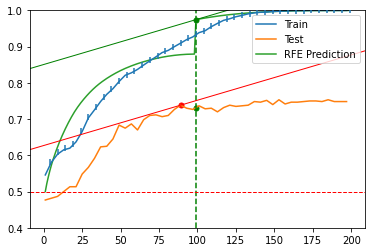

AT (89, 0.7383333333333333, 0.2983333333333334) WITH 40 ITERATIONS IN 0.6689461827278137 SECONDS : 0.0005099740901600569
PREDICT AT (99, 0.7316666666666667, 0.31366666666666665)
__main__.SVM_RFE_SAMPLING - 00:00:07.416905100


In [16]:
SVM_RFE_SAMPLING(5, 0.1, [0.8, 0.2], pstep=0.5)

(600, 200) (570,) (30,)


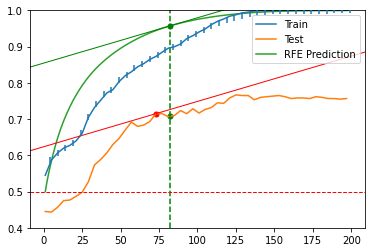

AT (73, 0.715, 0.30100000000000005) WITH 40 ITERATIONS IN 0.6950946092605591 SECONDS : 0.001836816057055444
PREDICT AT (82, 0.7074999999999999, 0.3160000000000001)
__main__.SVM_RFE_SAMPLING - 00:00:08.148073600


In [14]:
SVM_RFE_SAMPLING(5, 0.2, [0.8, 0.2], pstep=1.0)